In [175]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [176]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
total_data = pd.concat([train_data,test_data],axis = 0).reset_index(drop = True)

total_data_ = total_data.copy()

In [177]:

# convert all the column names to lower case. 
total_data_.columns = total_data_.columns.str.lower()

target_variable = 'response'
target = total_data_[target_variable]
total_data_.drop(columns=[target_variable, 'id'], inplace=True)


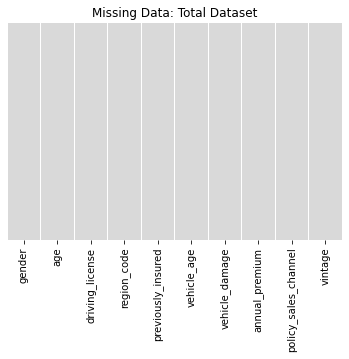

In [178]:
# Plot the missing data matrix
sns.heatmap(total_data_.isna(), yticklabels=False, cbar=False,cmap = 'tab20c_r')
plt.title('Missing Data: Total Dataset')
plt.show()

Interesting that there is no missing data here. 

In [179]:
# EDA data exploration . 
for i in total_data_.columns: 
    print('{} %'.format(i), round(sum(total_data_[i].isnull()) * 100/len(total_data_[i]),2))

gender % 0.0
age % 0.0
driving_license % 0.0
region_code % 0.0
previously_insured % 0.0
vehicle_age % 0.0
vehicle_damage % 0.0
annual_premium % 0.0
policy_sales_channel % 0.0
vintage % 0.0


In [180]:
total_data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508146 entries, 0 to 508145
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                508146 non-null  object 
 1   age                   508146 non-null  int64  
 2   driving_license       508146 non-null  int64  
 3   region_code           508146 non-null  float64
 4   previously_insured    508146 non-null  int64  
 5   vehicle_age           508146 non-null  object 
 6   vehicle_damage        508146 non-null  object 
 7   annual_premium        508146 non-null  float64
 8   policy_sales_channel  508146 non-null  float64
 9   vintage               508146 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 38.8+ MB


In [181]:
int2obj = ['driving_license','region_code', 'previously_insured']
# the above have less than 2 categories. 
# Definitely categorical. 


for col in int2obj:
    total_data_[col] = total_data_[col].astype('object')

    # policy_sales_channel are all discrete variables. It is a numerical encoding of categorical object variables.

float2obj = ['policy_sales_channel'] 

for col in float2obj:
    total_data_[col] = total_data_[col].astype('object')

obj2cat = ['gender','vehicle_age','driving_license','region_code', 'previously_insured', 'vehicle_damage', 'policy_sales_channel']

for col in obj2cat:
    total_data_[col] = total_data_[col].astype('category')

In [182]:
# Describe the continuous variables
total_data_.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
age,508146.0,38.808413,15.500179,20.0,25.0,36.0,49.00,85.0
annual_premium,508146.0,30554.453041,17146.574625,2630.0,24381.0,31661.0,39403.75,540165.0
vintage,508146.0,154.340123,83.668793,10.0,82.0,154.0,227.00,299.0


In [183]:
# Describe the categorical variables
total_data_.describe(include='category').transpose()

# what to do with the categories which have a lot of unique values. 
# region_code and policy_sales_channel are discrete continuous variables. 

,count,unique,top,freq
gender,508146,2,Male,274325
driving_license,508146,2,1,507097
region_code,508146.0,53.0,28.0,141937.0
previously_insured,508146,2,0,275076
vehicle_age,508146,3,1-2 Year,267015
vehicle_damage,508146,2,Yes,256248
policy_sales_channel,508146.0,157.0,152.0,179523.0


In [184]:
total_data_['vehicle_age'].unique()

['> 2 Years', '1-2 Year', '< 1 Year']
Categories (3, object): ['> 2 Years', '1-2 Year', '< 1 Year']

In [185]:
replace_map_vehicle_age = {'vehicle_age': {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}}

#### Encode the vehicle age: Replacement only since it is an ordinal variable

In [186]:
# not use label encoder as the it is a ordinal categorical variable.
total_data_1 = total_data_.copy()


total_data_1.replace(replace_map_vehicle_age, inplace=True)
total_data_1.vehicle_age.unique() #Results in appending a new column to df

array([2, 1, 0])

### Encode gender and vehicle_damage

In [187]:

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
total_data_1['gender'] = lb_make.fit_transform(total_data_1['gender'])
total_data_1['vehicle_damage'] = lb_make.fit_transform(total_data_1['vehicle_damage'])

total_data_1.head() #

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39


### Replacement and one-hot encoding

In [188]:
# Replacement and one-hot encoding of region codes and policy sales channel. 
# these are not continuous variables but categorical variables 
# that need to be reduced in dimensionality. 

<AxesSubplot:xlabel='region_code', ylabel='count'>

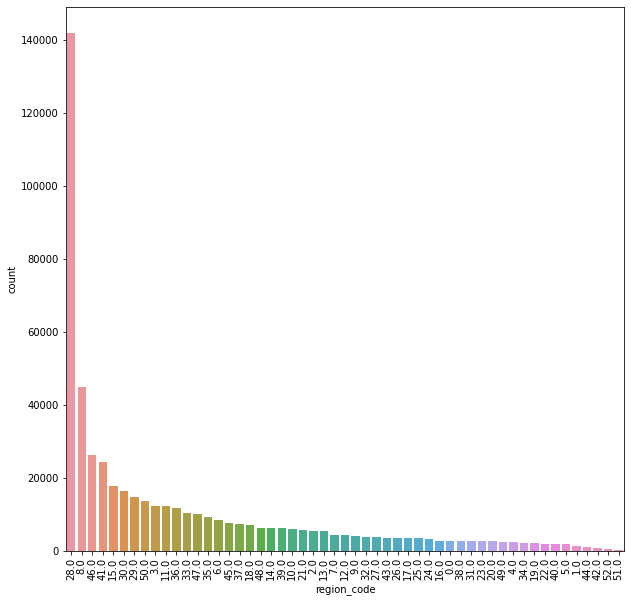

In [189]:
plt.figure(figsize=(10,10))

region_code_count = total_data_1.groupby(['region_code'], as_index=False)['gender'].count()
region_code_count.rename(columns={'gender':'count'}, inplace=True)
plt.xticks(rotation=90)
sns.barplot(x=region_code_count['region_code'], y=region_code_count['count'], order=region_code_count.sort_values('count', ascending=False).region_code)


In [190]:
region_code_count = total_data_1.groupby(['region_code'], as_index=False)['gender'].count()
region_code_count.rename(columns={'gender':'count'}, inplace=True)

region_code_count = region_code_count.sort_values('count', ascending=False)
region_code_count['cumsum'] = region_code_count['count'].cumsum()

region_code_count['percent'] = round(region_code_count['cumsum'] * 100/sum(region_code_count['count']),2)
region_code_count

,region_code,count,cumsum,percent
28,28.0,141937,141937,27.93
8,8.0,44900,186837,36.77
46,46.0,26357,213194,41.96
41,41.0,24400,237594,46.76
15,15.0,17750,255344,50.25
30,30.0,16276,271620,53.45
29,29.0,14843,286463,56.37
50,50.0,13657,300120,59.06
3,3.0,12349,312469,61.49
11,11.0,12328,324797,63.92


In [191]:
# 90% onwards group them into another category. 
# extract the region code counts that occupy > 90%
# region_code_count['percent']
region_code_list = region_code_count[region_code_count['percent'] >= 90].region_code
region_code_list
# Replace the <10% categories with a single category.
residue_region_codes = region_code_list.values
replace_map_comp = {'region_code' : {k: v for k,v in zip(residue_region_codes,[100]*len(residue_region_codes))}}

total_data_1.replace(replace_map_comp, inplace=True)

# Have to replace the less frequent categories with 
# another set of categories. 
total_data_1['region_code'].nunique()



31

<AxesSubplot:xlabel='policy_sales_channel', ylabel='count'>

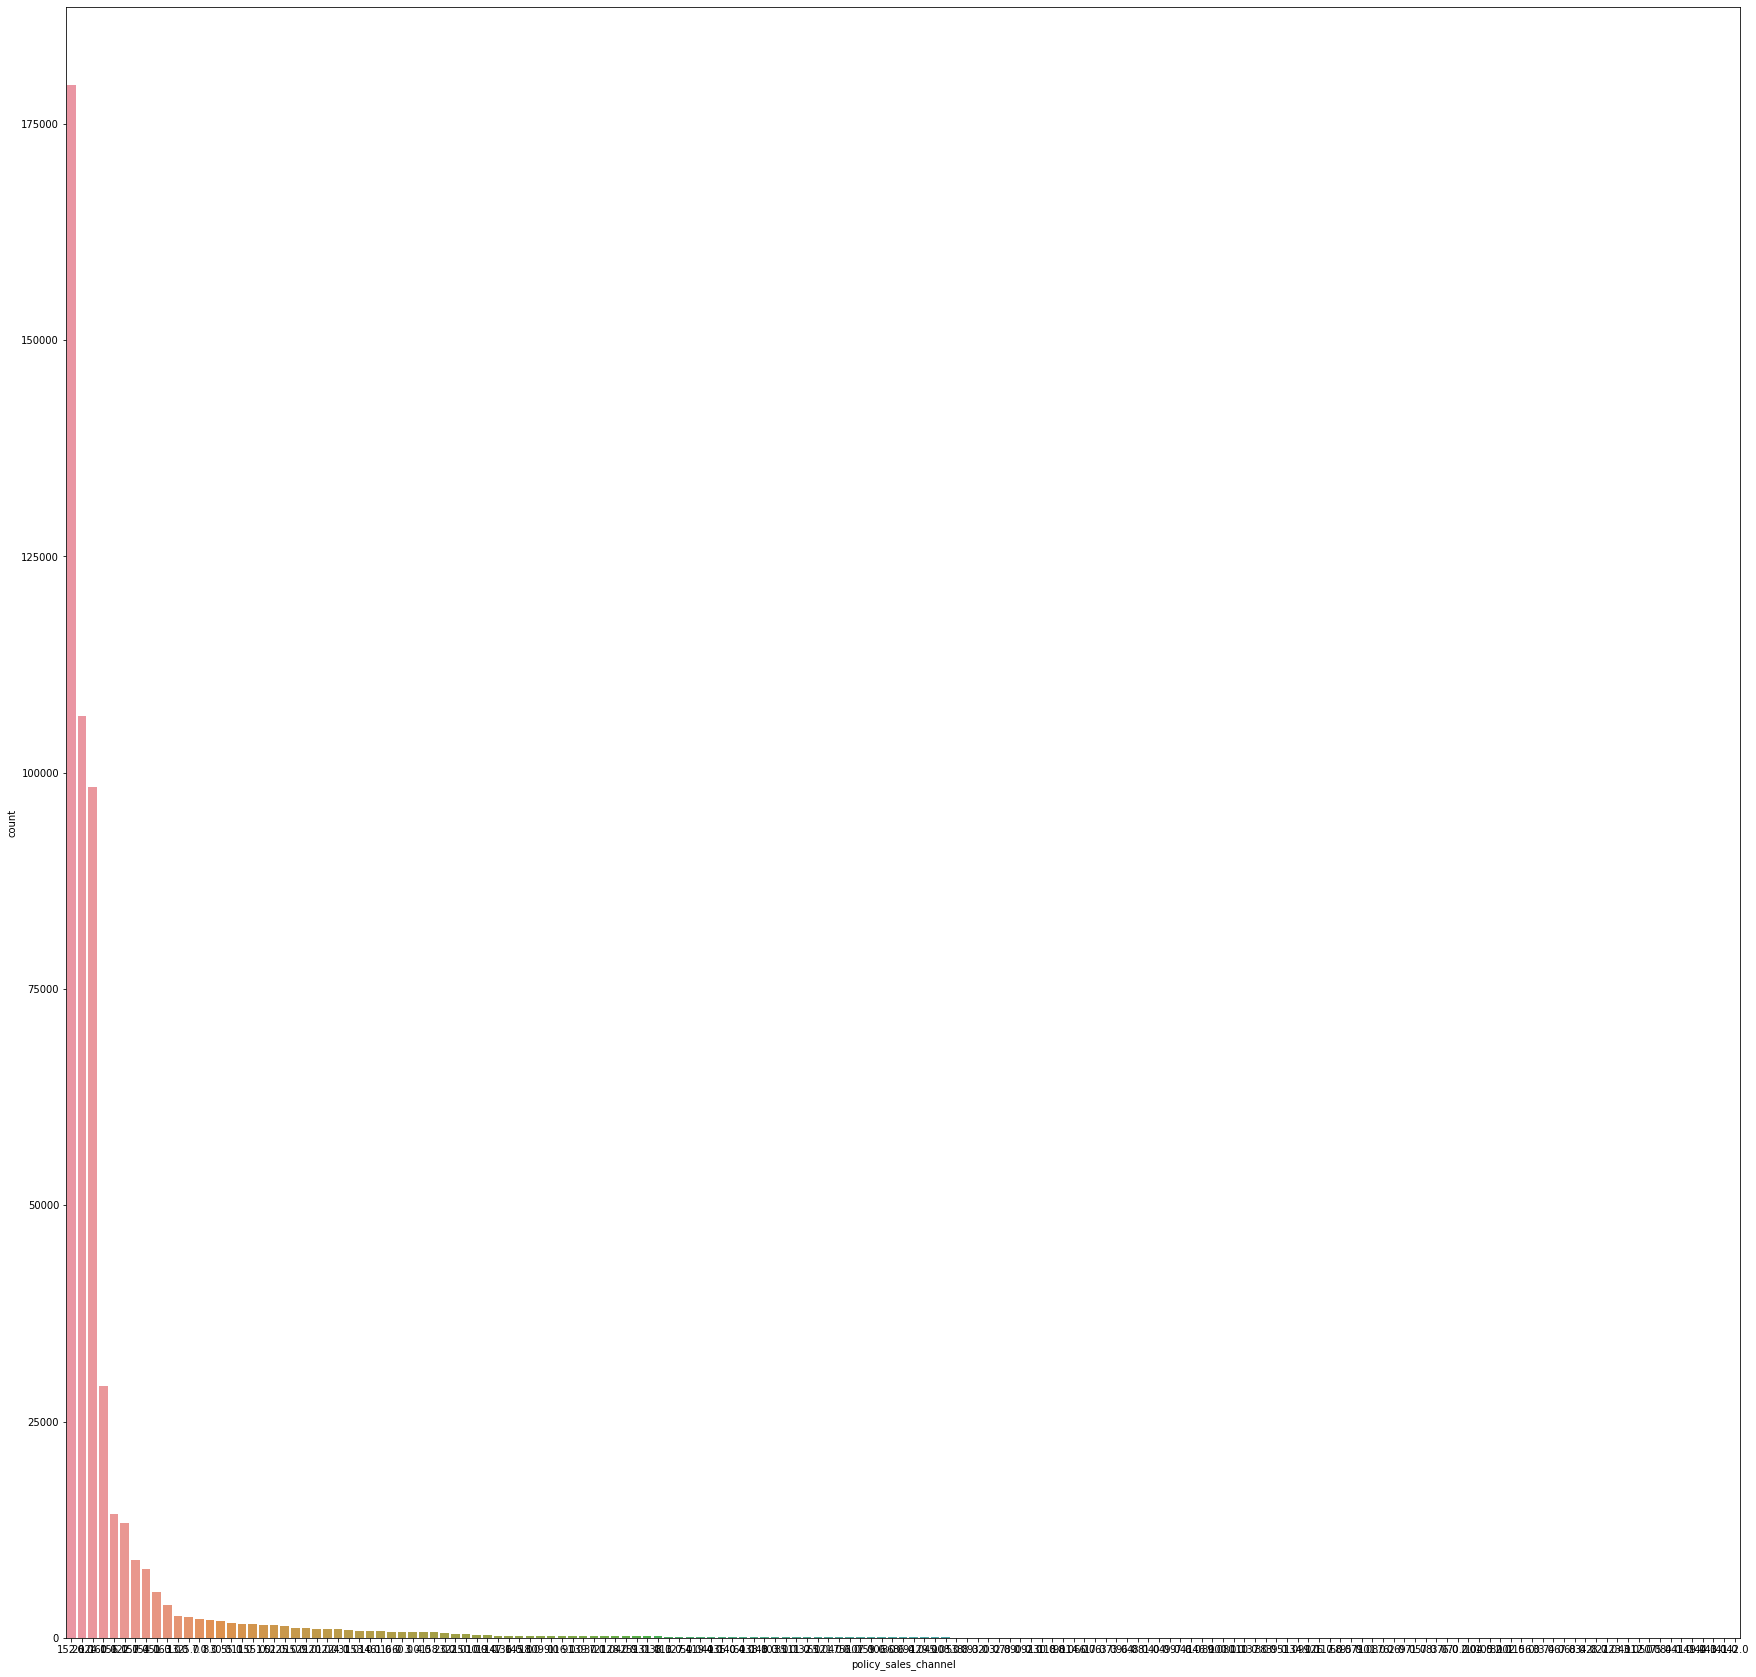

In [192]:
plt.figure(figsize=(30,30))

sales_channel_count = total_data_1.groupby(['policy_sales_channel'], as_index=False)['gender'].count()
sales_channel_count.rename(columns={'gender':'count'}, inplace=True)

sales_channel_count
sns.barplot(x=sales_channel_count['policy_sales_channel'], y=sales_channel_count['count'], order=sales_channel_count.sort_values('count', ascending=False).policy_sales_channel)


Both of the above graphs have a long-tail distribution. 

In [193]:
region_code_count = total_data_1.groupby(['policy_sales_channel'], as_index=False)['gender'].count()
region_code_count.rename(columns={'gender':'count'}, inplace=True)

region_code_count = region_code_count.sort_values('count', ascending=False)
region_code_count['cumsum'] = region_code_count['count'].cumsum()

region_code_count['percent'] = round(region_code_count['cumsum'] * 100/sum(region_code_count['count']),2)

region_code_count.head(30)
# select the policy sales channel contributing to less than 90%
region_code_count_select = region_code_count[region_code_count['percent'] >= 90.0]['policy_sales_channel'].values

replace_map_comp = {'policy_sales_channel' : {k: v for k,v in zip(region_code_count_select,[100]*len(region_code_count_select))}}

total_data_1.replace(replace_map_comp, inplace=True)

# Have to replace the less frequent categories with 
# another set of categories. 
total_data_1['policy_sales_channel'].nunique()

8

In [194]:
total_data_one_hot = total_data_1.copy()

# One-hot encode the remaining 30 categories. 
total_data_one_hot = pd.get_dummies(total_data_one_hot, columns=['region_code'], prefix=['region_code'])
# One-hot encode the remaining 6 categories. 
total_data_one_hot = pd.get_dummies(total_data_one_hot, columns=['policy_sales_channel'], prefix=['policy_sales_channel'])

In [196]:
total_data_one_hot.head()

,gender,age,driving_license,previously_insured,vehicle_age,vehicle_damage,annual_premium,vintage,region_code_2.0,region_code_3.0,...,region_code_48.0,region_code_50.0,policy_sales_channel_26.0,policy_sales_channel_100.0,policy_sales_channel_122.0,policy_sales_channel_124.0,policy_sales_channel_152.0,policy_sales_channel_156.0,policy_sales_channel_157.0,policy_sales_channel_160.0
0,1,44,1,0,2,1,40454.0,217,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,76,1,0,1,0,33536.0,183,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,47,1,0,2,1,38294.0,27,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,21,1,1,0,0,28619.0,203,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,29,1,1,0,0,27496.0,39,0,0,...,0,0,0,0,0,0,1,0,0,0
